### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy_dev.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_17824\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2 # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.003,0.51,0.005]
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
if not os.path.isdir('../modelfiles'):
    os.makedirs(P.workspace, exist_ok=True)
    
P.min_modlay_thick = [50, 50, 100, 100]

### 2. Meshing

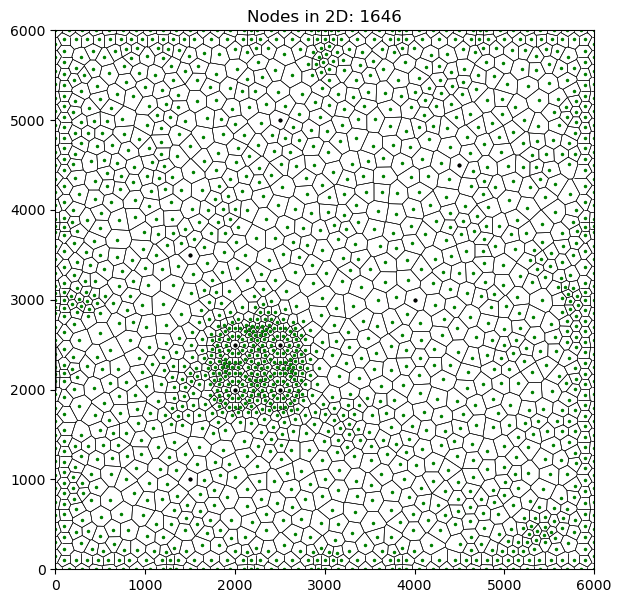

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [4]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [5]:
P.data
P.geomodel.feature_names()
#plot_bores(P)

dict_keys(['upper', 'upper_unconformity', 'lower'])

### 4. Flow model (Reference)

In [6]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy_dev.ipynb

# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  ref  ...
(16, 1646)


In [7]:
from shapely.geometry import MultiPoint
mp = MultiPoint(P.extdip_gs)
convex_hull = mp.convex_hull
mp
convex_hull

In [8]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        R.botm_geo
        wel_top = R.botm_geo[P.geo_pl-1, wel_icpl]
    wel_bot = R.botm_geo[P.geo_pl, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))

Well coords  (2000.0, 2000.0)  Well screen top and bottom  -186.0 -288.0
Well coords  (2500.0, 2000.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2000.0, 2500.0)  Well screen top and bottom  -164.0 -266.0
Well coords  (2500.0, 2500.0)  Well screen top and bottom  -148.0 -250.0


In [9]:
# Set up observations to be in the middle of geo layer
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm_geo[m, obs_icpl]
        lay_bot = R.botm_geo[m + 1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
print('\nobservation depths')
print(P.zobs)


observation depths
[[-137. -326. -439.]
 [ -25. -101. -326.]
 [ -35. -121. -336.]
 [ -74. -199. -375.]
 [ -25.  -73. -298.]]


In [10]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.525833
ref  has  26336  nodes.


In [11]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  23.153763


In [12]:
R.angle1.shape

(15594,)

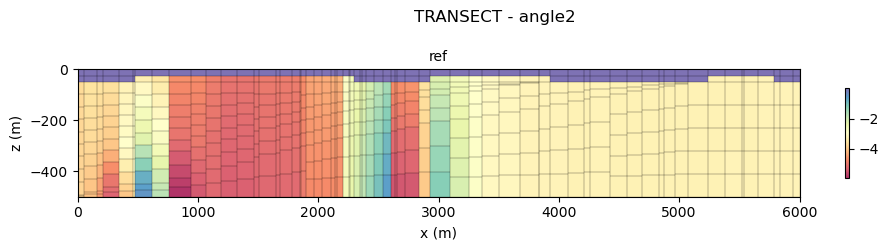

In [13]:
multiplot_prop_transect(P, models = [R], array = 'angle2', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

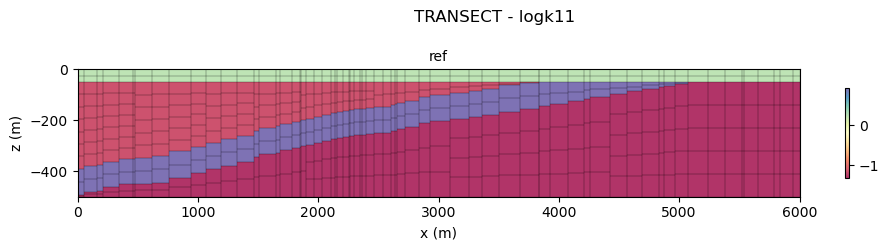

In [14]:
multiplot_prop_transect(P, models = [R], array = 'logk11', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [15]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  65.981695


In [16]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  126.814456


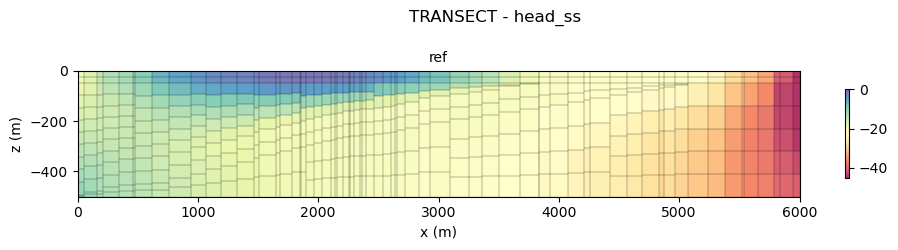

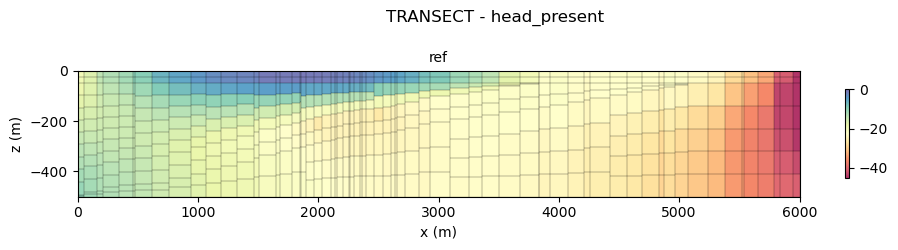

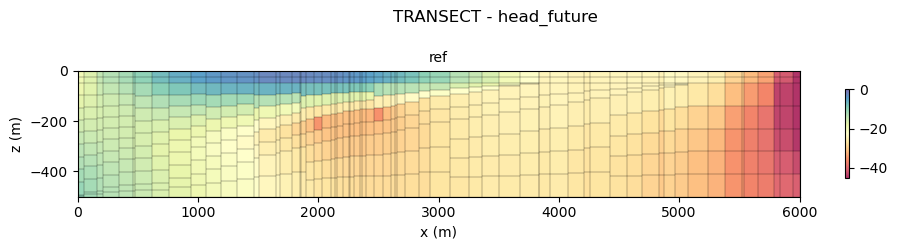

In [17]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

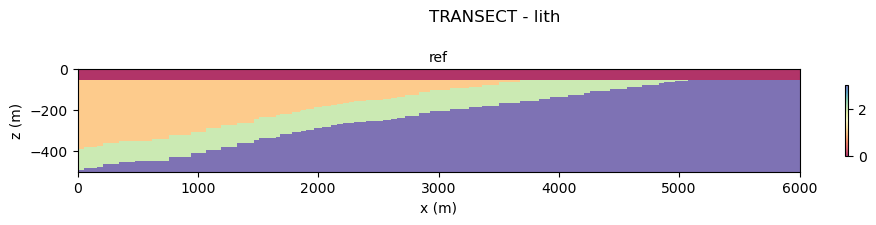

In [18]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [19]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [20]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [21]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

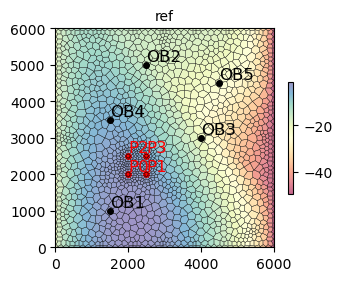

In [22]:
plot_bylayer(P, models = [R], layer = 0)#, vmin = -20, vmax = 5) 

In [23]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [24]:
# REF
print(logfunc([1.7, 0.07, 8.2, 0.05])) 
print(logfunc([0.12,0.003,0.51,0.005]))
print(logfunc([0.00009, 0.00007, 0.00002, 0.00008]))
print([0.12, 0.1, 0.1, 0.1])

[ 0.230449 -1.154902  0.913814 -1.30103 ]
[-0.920819 -2.522879 -0.29243  -2.30103 ]
[-4.045757 -4.154902 -4.69897  -4.09691 ]
[0.12, 0.1, 0.1, 0.1]


In [25]:
# 0.5338380809705878 -1.0163404908499516 0.407196345623647 -1.2991062028893283 -0.3522089655250348 -2.769605014475321 -0.2873586606337365 -2.5146041514511683 -4.580914021673361 -4.207829333750281 -4.657410786968811 0.1132872706160005
#    0.1132872706160005

In [26]:
loghk0, loghk1, loghk2, loghk3 = 0.5338380809705878, -1.0163404908499516, 0.407196345623647, -1.2991062028893283
logvk0, logvk1, logvk2, logvk3 = -0.3522089655250348, -2.769605014475321, -0.2873586606337365, -2.5146041514511683
logss1, logss2, logss3 = -4.580914021673361, -4.207829333750281, -4.657410786968811
sy0 =  0.1132872706160005
cp =  -25  

P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
P.sy = [sy0, 0.1, 0.1, 0.1]

In [27]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy_dev.ipynb
# Initiate TEST
P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
T = Model('test', P, plan = 'vor', transect = 'con') 
T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
T.create_prop_arrays(P)         # Create property arrays (NPF)
T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(T.modelname, ' has ', T.ncell_disu, ' nodes.')

T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  test  ...


C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


(17, 1646)
   Creating property arrays for  test  ...
   Adding flow packages to  test  ...
   Time taken =  1.627023
test  has  13888  nodes.
   Writing simulation and gwf for  test  ...
Period =  Steady 
   Model success =  True
   run_time =  27.15557
   Writing simulation and gwf for  test  ...
Period =  Past 
   Model success =  True
   run_time =  54.277966
   Writing simulation and gwf for  test  ...
Period =  Future 
   Model success =  True
   run_time =  116.127884


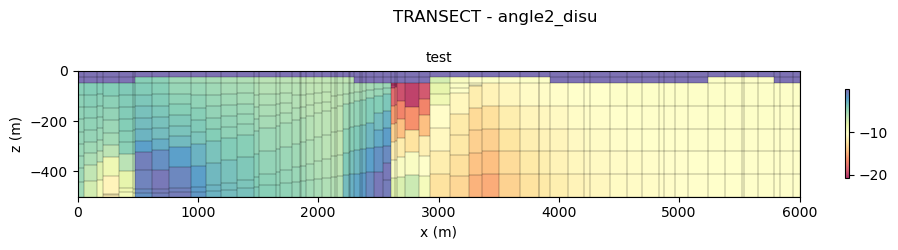

In [28]:
T.angle2_disu = T.gwf.npf.angle2.array

multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [29]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('test')


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package npf...
    loading package ic...
    loading package sto...
    loading package wel...
    loading package chd...
    loading package rch...
    loading package obs...
    loading package oc...
  loading ims package test...


In [30]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

minimum cell thickness = 1.000000 at node 29
XYZ problem =  2061.8033988749894 2690.2113032590305 -64.5
cell width approx  69.93597644027614
cell length approx  108.76173161677343
cell thickness 29.0


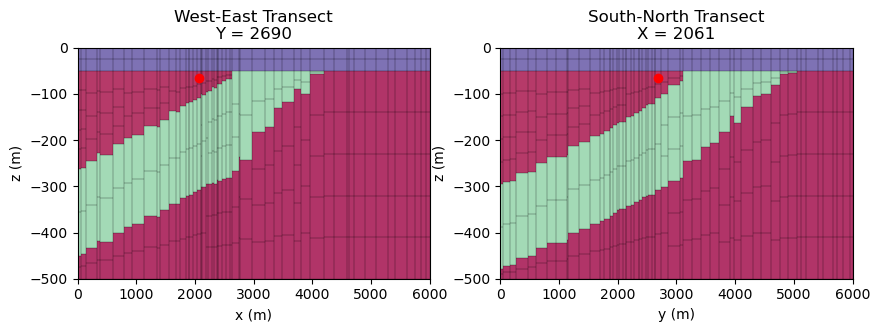

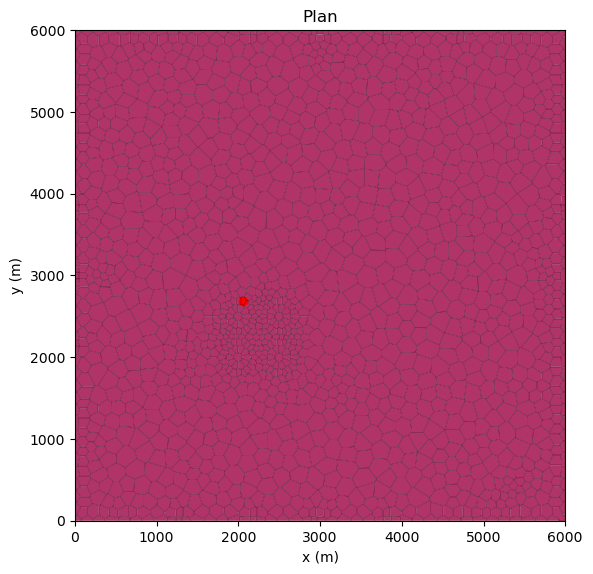

In [31]:
node = 3415-1

print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))

X = T.gwf.modelgrid.xyzcellcenters[0][node]
Y = T.gwf.modelgrid.xyzcellcenters[1][node]
Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = T.gwf.modelgrid.xyzvertices[0][node]
yv = T.gwf.modelgrid.xyzvertices[1][node]
zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

### 14. Create "truth" observations and plot observations

In [32]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [33]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [34]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

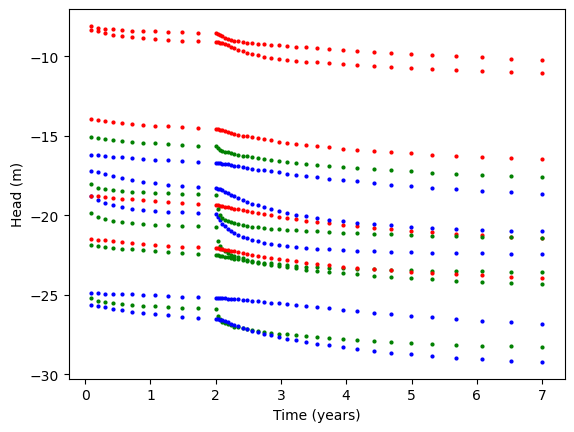

In [35]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

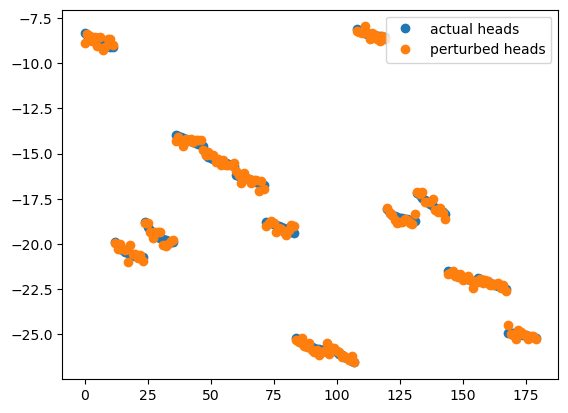

In [36]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [37]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy_dev.ipynb
print(P.hk, P.vk)
print(logfunc(P.hk), logfunc(P.vk))

loop2flopy routines loaded!
[3.4185196528205717, 0.09630736689863766, 2.5538556462386146, 0.05022197610867759] [0.44441737974832896, 0.0016997888868923487, 0.5159900646098728, 0.0030577068667177]
[ 0.533838 -1.01634   0.407196 -1.299106] [-0.352209 -2.769605 -0.287359 -2.514604]


In [38]:
#k_min = [-1, -3, -1, -3,   -3,  1, -2.5, -2]
#k_max = [1,   -1,  1,    -1, -0.5, -1, -0.5, -0.5]
#klist =[0.,-1.,0.69897,-1.,-1.,-2.,-0.30103,-2.] 
k_min = [0,-2,0,-2]
k_max = [1,-1,1,-1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(4)]
"""plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"""

"plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')\nplt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"

In [39]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i]-1)
    Width.append(0.5)
    Min.append(k_min[i]-1) 
    Max.append(k_max[i]-1)
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [40]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 100 
minsamp = 169 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [41]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -150, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [42]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [43]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [44]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

In [45]:
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

0.34126293446270817 -1.5496546091980048 0.5602912052503829 -1.5206989703550258 -0.0572204365336213 -2.758662315886628 -0.3828185109030987 -2.700978277829848 -4.3031216787956685 -4.682317019429256 -4.4418215319038925 0.11801954288617832 -103.82717744130466
   Creating lithology and discretisation arrays for  run  ...
(16, 1646)
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.668631
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.898269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.228074
Initial Likelihood for chain  0  =  -465876.99454608344
0.3945762722187317 -1.850555957785435 0.5840647302027787 -1.9407523393271424 -0.9225727927920189 -2.8011755845806956 -0.31370665371253026 -2.5772088101859216 -4.894142316803108 -4.945378529164109 -4.05762910953721 0.0683329569728953 -36.77549330159374
   Creating lithology and discretisation arrays for  run  ...
(16, 1646)
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.898571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.985134
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  79.614376
Initial Likelihood for chain  1  =  -630732.8619371732
0.07326821363707037 -1.4033097904697018 0.8372693058010982 -1.1163959008105162 -0.6992247618615702 -2.1316557600832904 -0.2363619176181707 -2.638906420136013 -4.595676186751881 -4.666946903860387 -4.2500174376589115 0.17755489282501136 -218.69184492498243
   Creating lithology and discretisation arrays for  run  ...
(16, 1646)
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.317597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.398528
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.183209
Initial Likelihood for chain  2  =  -3370.654914328067
0.41890004816114323 -1.9669041670001755 0.36109802728400386 -1.2475422603627626 -0.13746038370108737 -2.9327829195741337 -0.28033671658874637 -2.9625242141481496 -4.035507002005146 -4.603045148481618 -4.114748977907328 0.17452543438988222 -97.17079287207443
   Creating lithology and discretisation arrays for  run  ...
(16, 1646)
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.588504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.614458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  False
   Re-writing IMS - Take 2
Model success2 =  False


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = '../modelfiles')
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    #ax.set_xlim([5000, 6000])
    #ax.set_ylim([0,1000])
    
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  

In [ ]:
node = 4155-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""